# Replication for results in Davidson et al. 2017. "Automated Hate Speech Detection and the Problem of Offensive Language"

In [1]:
!pip install vaderSentiment
!pip install textstat
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
from imblearn.over_sampling import SMOTE

%matplotlib inline

## Loading the data

In [2]:
train  = pd.read_csv("./train_E6oV3lV.csv")
test = pd.read_csv("./test_tweets_anuFYb8.csv")
train  = pd.read_csv("./Data/TrainingData/train.csv")
val = pd.read_csv("./Data/TrainingData/test.csv")
test = pd.read_csv("./Data/TrainingData/dev.csv")
frames = [train, val, test]
train = pd.concat(frames)

The training dataset consists of three coloumns as shown below. The tweets are put on a coloumn named Phrase, which are labelled with a binary sentiment values. Each tweet have an id in the Coloumn phrase_ids. There are 31962 intances in the train dataset.

In [3]:
train

,Unnamed: 0,phrase_ids,sentiment_values,Phrase
0,0,1,0,@user when a father is dysfunctional and is s...
1,2,3,0,bihday your majesty
2,3,4,0,#model i love u take with u all the time in ...
3,4,5,0,factsguide: society now #motivation
4,5,6,0,[2/2] huge fan fare and big talking before the...
...,...,...,...,...
3221,31916,31917,0,happy tuesday!! feeling fantastic today. looki...
3222,31922,31923,0,i love my friends! happy sunday funday everyon...
3223,31931,31932,0,@user i c sociopaths low iq satanic everything...
3224,31939,31940,0,whew ð it's a productive and #friday!!!


The majority of the instances are neutral tweets, which explains the almost zero mean of the "label" column with Standard deviation of 0.25. Obviously, this dataset suffers data imbalance  reflects the unequal distribution of sentiment classes within the dataset as more than 75% of the instances are non-offensive. Therefore, riskin the model to be biased. It also impacts the correlations between features.

In [4]:
train.describe()

,Unnamed: 0,phrase_ids,sentiment_values
count,31962.000000,31962.000000,31962.000000
mean,15980.500000,15981.500000,0.070146
std,9226.778988,9226.778988,0.255397
min,0.000000,1.000000,0.000000
25%,7990.250000,7991.250000,0.000000
50%,15980.500000,15981.500000,0.000000
75%,23970.750000,23971.750000,0.000000
max,31961.000000,31962.000000,1.000000


### Columns key:


label = class label for tweets.

    0 - neutral
    1 - offensive  language
 



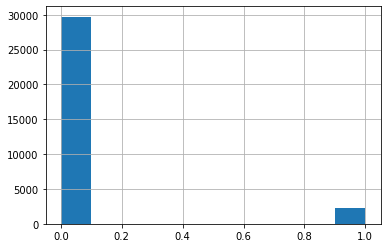

In [5]:
train['sentiment_values'].hist()

## Feature generation


Each tweet have been turned into lowercase and porter stemmed, which is reducing the inflictions of similar words to a common stem even if it is not a valid word in the dictionary. for example, the words “retrieval”, “retrieved”, “retrieves” reduce to the stem “retrieve”. Also, bigram, unigram, and trigram features are created,in which n-gram is a contiguous sequence of n items from a given tweet, each weighted by its TF-IDF. For the sake of capturing the syntax sentences structure, Penn Part-of-Speech (POS) tags, or simply tagging, have been structured on these unigrams, bigrams, and trigrams.

Firstly, the stopwards have been downloaded from nltk package

In [6]:
nltk.download('stopwords')
stopwords=stopwords = nltk.corpus.stopwords.words("english")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ramiatef/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Other common useless strings and hashtags have been added to the list of stopwords including rt for retweet and a common hashtag of #ff

In [8]:

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)


Then, three functions have been created. Firstly, preprocess( ), which removes excessive spaces between words, URLS and tweet´s mentions since theya re not usefull for sentiment analysis.
Secondly, tokenize is created for making an array of substrings of words by splitting words before removing word´s punctuation and making all words lower case.After that, the porter stemmer have been applied, which is explained above. Thirdly, a function which split words of the tweets as an array of substrings i.e tokens without stemming the words.

In [9]:

def preprocess(text_string):
    
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, '', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

#initializing the stemmer
stemmer = PorterStemmer()

def tokenize(tweet):
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens



def basic_tokenize(tweet):
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()



A TfidfVectorizer have been intialized, which transforms the tweets to feature vectors that can be used as input to estimator using the 2 functions created above as inputs for this vectorizer. As a result, this vectorizer will create tfidf matrix with as many rows as the number of tweets. the coloumns header is representing the ngrams scores of tokens, ranging from 1 to 3 grams.



In [10]:
vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [11]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [12]:
tfidf = vectorizer.fit_transform(train.Phrase).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [13]:
idf_vals
idf_dict

{0: 1.6014329482237653,
 1: 4.397824065120009,
 2: 6.894966161666848,
 3: 7.015594149455462,
 4: 5.969625594272775,
 5: 7.634633357861686,
 6: 7.068237882940885,
 7: 6.990276341471173,
 8: 9.292861434465218,
 9: 8.376570702591064,
 10: 6.15194715106673,
 11: 6.929651719654737,
 12: 8.194249145797109,
 13: 8.153427151276853,
 14: 7.068237882940885,
 15: 6.917955679891547,
 16: 8.236808760215904,
 17: 7.81695491465564,
 18: 4.14682150336276,
 19: 8.887396326357054,
 20: 7.611102860451492,
 21: 7.182648234118629,
 22: 8.153427151276853,
 23: 8.376570702591064,
 24: 6.190519425852969,
 25: 4.995576028246427,
 26: 7.109623099103739,
 27: 6.7279120770036815,
 28: 7.971105594482899,
 29: 7.054814862608744,
 30: 6.328877859225807,
 31: 8.664252775042844,
 32: 2.454590219013667,
 33: 5.648717874192673,
 34: 4.670342610142514,
 35: 4.367420986432194,
 36: 4.953938040208843,
 37: 5.7519021104279044,
 38: 4.9123985217675195,
 39: 7.971105594482899,
 40: 7.277958413922954,
 41: 4.715576451966662,
 

The Part-of-speech tagging is performed using nltk library, which is basically a grammatical tagging or word-category disambiguation of identification of words in the sentences as nouns, verbs, adjectives, adverbs, etc.


In [14]:
#Get POS tags for tweets and save as a string
nltk.download('averaged_perceptron_tagger')
tweet_tags = []
for t in train.Phrase:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ramiatef/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


The TFIDF vectorizer us used to create the POS TF matrix for the POS tags, which will be concatinated with the previous TFIDF vectorizer.


In [15]:
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

After getting the TFIDF and the POS TF matrix, other features as the mentions and hashtags will be used to get extra information from the tweets, which will be added as new coloumn for consructed matix created eariler. A SentimentAnalyzer tool is implemented to facilitate Sentiment Analysis tasks using NLTK features and classifiers, which classify tweets into positive, negative, neutral and compound. 

In [16]:
sentiment_analyzer = VS()

def count_twitter_objs(text_string):

    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, '', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet)
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [17]:
feats = get_feature_array(train.Phrase)

The three created matrixes are concatinated to create a hihgly complex matrix carrying many redundant information about the tweets.

In [18]:
M = np.concatenate([tfidf,pos,feats],axis=1)

In [19]:
M.shape

(31962, 4496)

The name of the features computed respectively. 

In [20]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

Then the list of the coloumns names have been created below

In [21]:
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

# Running the model

The best model was selected using a GridSearch with 5-fold CV.

In [22]:
X = pd.DataFrame(M)
y = train['sentiment_values'].astype(int)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 29720, 1: 29720})


In [23]:
from sklearn.model_selection import train_test_split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [38]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

Obviously, the dataframe created from the constructed matrix contains a lot of redundant information. For the sake of avoiding the curse of dimensionality, we used the logistic regression to give almost zero coefficients for the predictors (features) depending on their degree of importance in the model for prediction of the sentiment.

In [50]:
pipe = Pipeline(
        [('select', SelectFromModel(LogisticRegression(class_weight='balanced',
                                                  penalty="l2", C=0.01))),
        ('model', LogisticRegression(class_weight={ 1:0.9, 0:0.1 },penalty='l2'))])

In [51]:
param_grid = [{}] 

In [52]:
grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=2, 
                                              random_state=42).split(X_train, y_train), 
                           verbose=2)

In [53]:
model = grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver op

[CV] ................................................. , total=  16.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.6s remaining:    0.0s
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver opt

[CV] ................................................. , total=  13.6s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   30.2s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    

In [54]:
y_preds = model.predict(X_test)

## Evaluating the results

In [55]:
report = classification_report( y_test, y_preds )

As shown, the accuracy of prediction of the logistic regression model is 0.87

In [56]:
print(report)

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      2957
           1       0.34      0.68      0.46       240

    accuracy                           0.88      3197
   macro avg       0.66      0.79      0.69      3197
weighted avg       0.92      0.88      0.90      3197



It´s obvious in the confusion matrix that more neutral tweets have been classified as hatefull that the opposite.

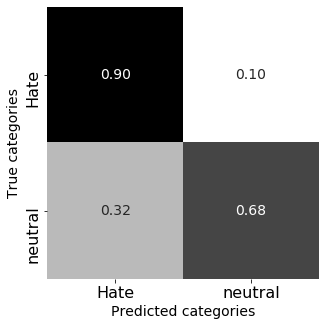

In [57]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((2,2))
for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','neutral']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 14},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=16)


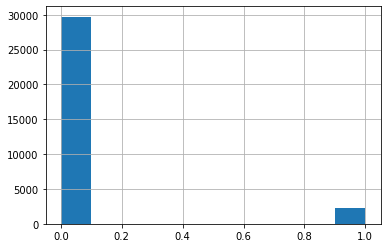

In [58]:
#True distribution
y.hist()

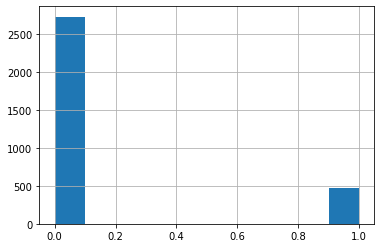

In [59]:
pd.Series(y_preds).hist()

In [60]:
train['sentiment_values']

0       0
1       0
2       0
3       0
4       0
       ..
3221    0
3222    0
3223    0
3224    0
3225    0
Name: sentiment_values, Length: 31962, dtype: int64